El código para graficar la eof y calcularla lo obtuve de un ejemplo de la página web de la librería que use para calcular la eof: https://ajdawson.github.io/eofs/examples/nao_xarray.html

In [1]:
import numpy as np

import xarray as xr
from eofs.xarray import Eof

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import os

Creo un nuevo mapa de color para que los datos cercanos a 0 sean completamente blancos

In [2]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

bwr = mpl.colormaps['bwr'].resampled(10)
newcolors = bwr(np.linspace(0, 1, 10))
white = np.array([256/256, 256/256, 256/256, 1])
newcolors[4:6, :] = white
newcmp = ListedColormap(newcolors)

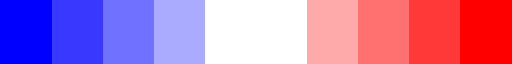

In [3]:
newcmp

# Slice the data depending of the hemisphere and the season

In [4]:
def Season_netcdf(file, hemisph, season): # hemisph(0=north, 1=south)       season(0=summer, 1=winter)

    verano = [0, 1, 2, 10, 11]
    invierno = [4, 5, 6, 7, 8]
    
    ds = xr.open_dataset(file)

    hgt = ds['hgt'].values
    time = ds['time'].values
    lon = ds['lon'].values
    lat = ds['lat'].values
    level = ds['level'].values

    hgt = hgt.reshape((77, 12, 1, 29, 144))

    time = time.reshape((77,12))

    if (hemisph==0 and season==0):
        hgt_season = hgt[:, invierno, :, :, :]  # (años, 5 meses, level, lat, lon)
        time = time[:, invierno]

    elif (hemisph==0 and season==1):
        hgt_season = hgt[:, verano, :, :, :]  # (años, 5 meses, level, lat, lon)
        time = time[:, verano]

    elif (hemisph==1 and season==0):
        hgt_season = hgt[:, verano, :, :, :]  # (años, 5 meses, level, lat, lon)
        time = time[:, verano]

    elif (hemisph==1 and season==1):
        hgt_season = hgt[:, invierno, :, :, :]  # (años, 5 meses, level, lat, lon)
        time = time[:, invierno]

    hgt_season = hgt_season.reshape((77 * 5, 1, 29, 144))

    time = time.reshape(77 * 5)

    HGT = xr.DataArray(
        data=hgt_season,
        dims=["time", 'level', "lat", "lon"],
        coords=dict(
            time=time,
            lon=lon,
            lat=lat,
            level=level))

    return HGT

# Calculate the EOF

In [5]:
def Calc_eof(HGT):
    HGT = HGT - HGT.mean(dim='time')

    # Create an EOF solver to do the EOF analysis. Square-root of cosine of
    # latitude weights are applied before the computation of EOFs.
    coslat = np.cos(np.deg2rad(HGT.coords['lat'].values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(HGT, weights=wgts)
    
    # Retrieve the leading EOF, expressed as the covariance between the leading PC
    # time series and the input SLP anomalies at each grid point.
    eof = solver.eofsAsCorrelation(neofs=1)

    return eof

# Plot the EOF

In [6]:
def Graph_eof(eof, file, season):

    # Periodic Conditions:

    lat = eof["lat"].values
    lon = eof["lon"].values
    eof_aux = eof.values[0][0]
    
    eof_dat = np.zeros([29,145])
    eof_dat[:,:144] = eof_aux
    eof_dat[:,144] = eof_aux[:,0]
    
    lon = np.append(lon, 360)

    eof = xr.DataArray(
                        data=eof_dat,
                        dims=["lat", "lon"],
                        coords=dict(lon=lon, lat=lat))
    
    # Plot the leading EOF expressed as covariance in the European/Atlantic domain.
    clevs = np.linspace(-1, 1, 11)
    
    if ("N" in amz.name):
        proj = ccrs.Orthographic(central_longitude=0, central_latitude=90)    
    elif ("S" in amz.name):
        proj = ccrs.Orthographic(central_longitude=0, central_latitude=-90)
        
    ax = plt.axes(projection=proj)
    ax.coastlines()
    ax.set_global()
    
    eof.plot.contourf(ax=ax, levels=clevs, cmap=newcmp,
                             transform=ccrs.PlateCarree(), add_colorbar=True)

    if (season==0):
        ax.set_title(f'EOF expressed as correlation {file} nov-mar', fontsize=16)
        plt.savefig(f"Plots/{file}_nov-mar.png")
        
    elif (season==1):
        ax.set_title(f'EOF expressed as correlation {file} may-sept', fontsize=16)
        plt.savefig(f"Plots/{file}_may-sept.png")
    
    plt.show()

# Main


In [7]:
!mkdir Plots

mkdir: cannot create directory ‘Plots’: File exists


In [8]:
directory = os.scandir("./AMZ")

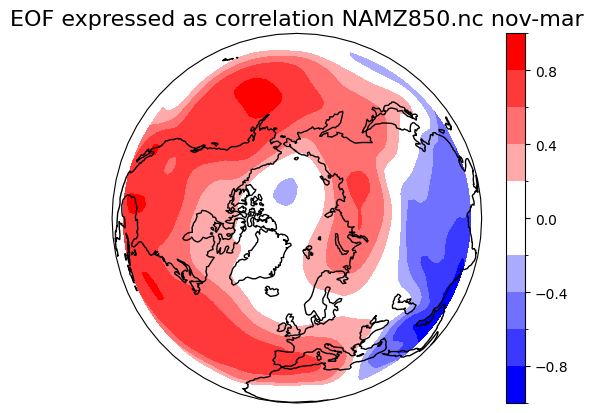

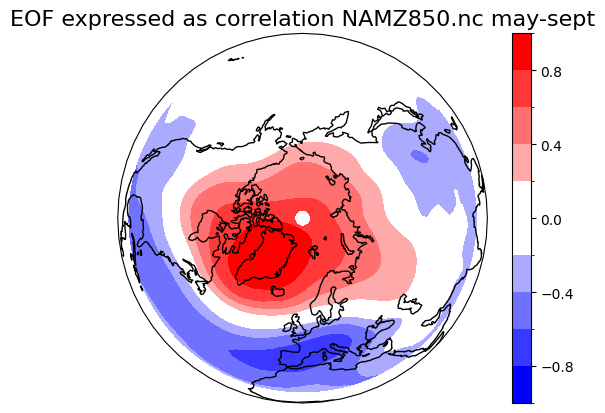

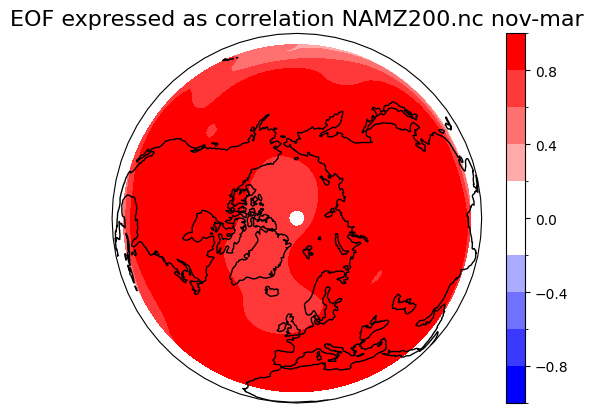

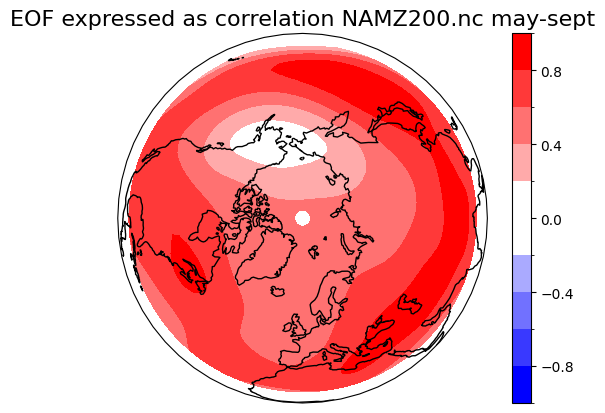

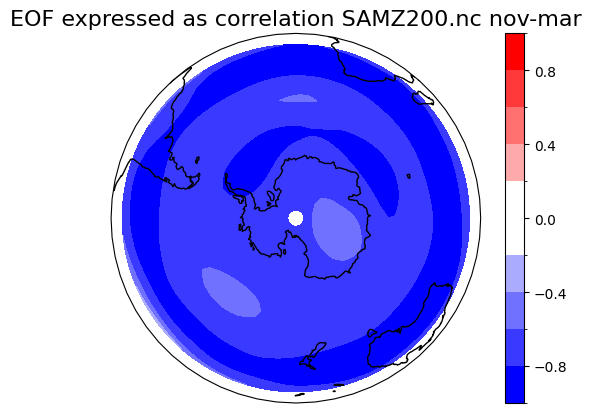

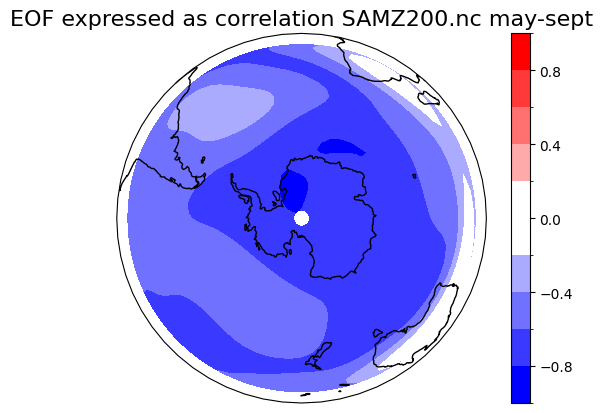

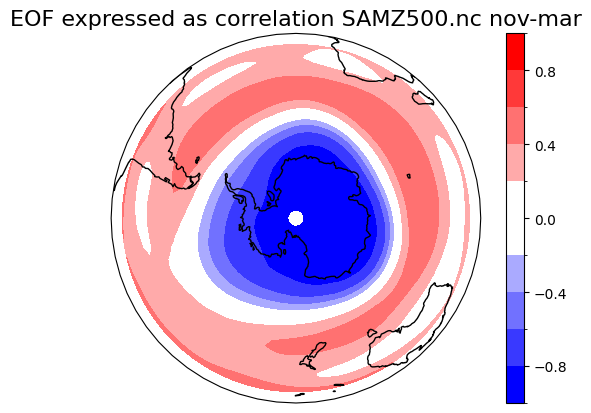

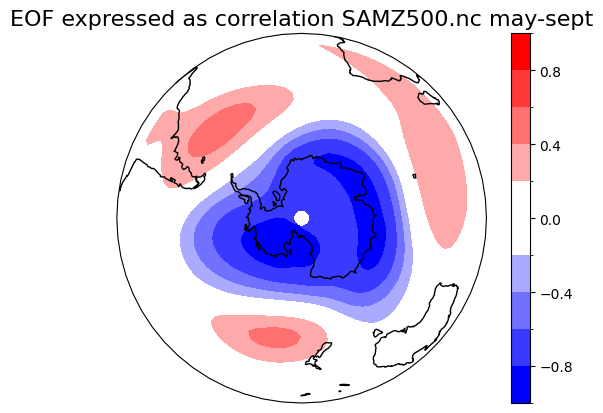

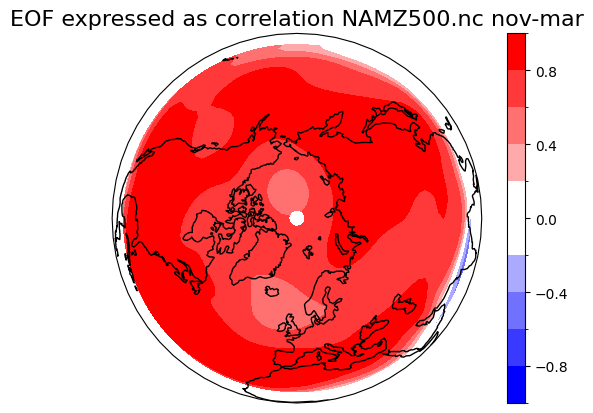

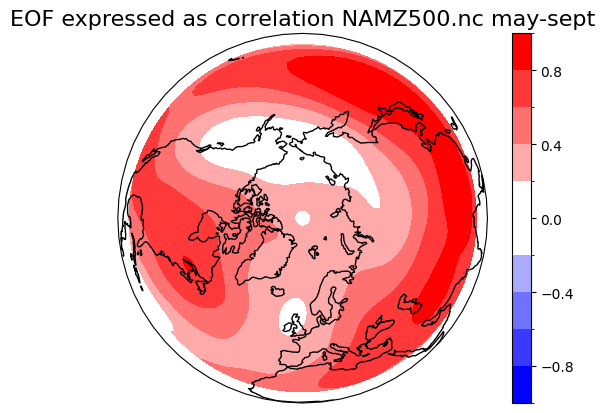

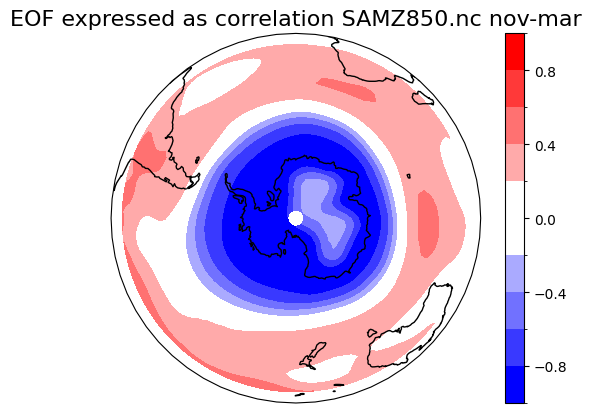

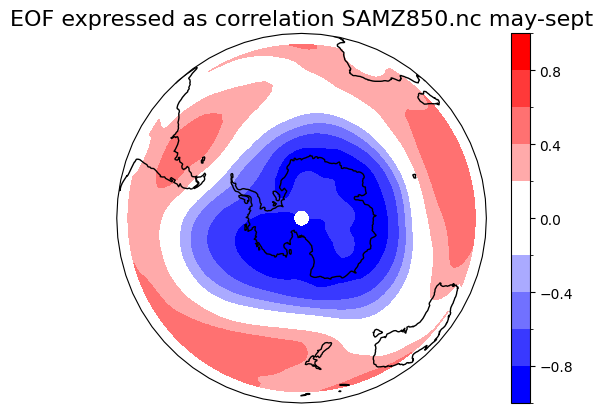

In [9]:
for amz in directory:
    for i in range(2):    # Seasons

        if ("N" in amz.name):
            HGT = Season_netcdf(f"AMZ/{amz.name}",0,i)   # North
        elif ("S" in amz.name):
            HGT = Season_netcdf(f"AMZ/{amz.name}",1,i)   # South
            
        eof = Calc_eof(HGT)
    
        Graph_eof(eof, amz.name, i)